# Uniform LRP

Experiment with LRP.

## Setup

Load image into notebook

In [1]:
import cv2

# Returns a numpy array in BGR color space, not RGB
img = cv2.imread('castle.jpg')

# Convert from BGR to RGB color space
img = img[...,::-1]

# img.shape is (224, 224, 3), where 3 corresponds to RGB channels
# Divide by 255 to normalize pixel values to [0,1]
img = img/255.0

In [2]:
import torch
import numpy

# reshape converts row vectors to column vectors 
# {mean and std have shape torch.Size([1, 3, 1, 1, 1])
mean = torch.Tensor([0.485, 0.456, 0.406]).reshape(1,-1,1,1)
std  = torch.Tensor([0.229, 0.224, 0.225]).reshape(1,-1,1,1)

# X has shape (1, 3, 224, 224)
X = (torch.FloatTensor(img[numpy.newaxis].transpose([0,3,1,2])*1) - mean) / std

## LRP implementation from slides

[Source](http://www.interpretable-ml.org/ecml2020tutorial/ecml2020-xai-tutorial-3.pdf): Part 3 of _Explainable ML, Basics and Extensions_

### Gradient x Input

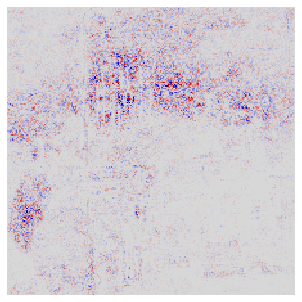

In [3]:
import utils

# Load VGG-16 Model
import torchvision
model = torchvision.models.vgg16(pretrained=True)
model.eval()

# Prepare to compute input gradient
X.grad = None
X.requires_grad_(True)

# Compute explanation
model.forward(X)[0,483].backward()
R = (X*X.grad)

# Visualize explanation
utils.heatmap(R[0].sum(dim=0).detach().numpy(), 4,4)

### LRP

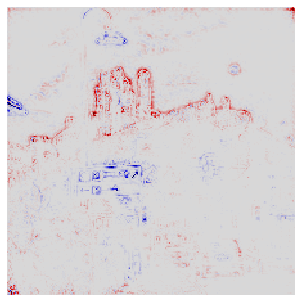

In [4]:
import copy

# Build an equivalent forward pass where part of it is detached
class GammaConv(torch.nn.Module):

  def __init__(self, conv, gamma):
    torch.nn.Module.__init__(self)
    self.conv = conv
    self.pconv = copy.deepcopy(conv)
    self.pconv.weight = torch.nn.Parameter(conv.weight+gamma*conv.weight.clamp(min=0))

  def forward(self, X):
    z = self.conv.forward(X)
    zp = self.pconv.forward(X)
    return zp * (z / zp).detach()


# Replace layers by modified layers
# model.features returns feature extraction layers
f = model.features
for i in [2]: f[i] = GammaConv(f[i], 1)
for i in [5,7]: f[i] = GammaConv(f[i], 0.3)
for i in [10,12,14]: f[i] = GammaConv(f[i], 0.1)
for i in [17,19,21]: f[i] = GammaConv(f[i], 0.03)
for i in [24,26,28]: f[i] = GammaConv(f[i], 0.01)

# Apply Gradient x Input
# Prepare to compute input gradient
X.grad = None
X.requires_grad = True

# Compute explanation
model.forward(X)[0,483].backward()
R = (X*X.grad)

# Visualize explanation
utils.heatmap(R[0].sum(dim=0).detach().numpy(), 4,4)